# 调整树的参数：max_depth & min_child_weight
(粗调，参数的步长为2；下一步是在粗调最佳参数周围，将步长降为1，进行精细调整)

In [1]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据

In [2]:
# path to where the data lies
dpath = './data/'
train = pd.read_csv(dpath +"RentListingInquries_FE_train.csv")
# train.head()

## 准备数据

In [3]:
y_train = train['interest_level']

train = train.drop(['interest_level'], axis=1, inplace = False)
X_train = train

In [4]:
# 训练样本6w+，交叉验证太慢，用train_test_split估计模型性能
from sklearn.model_selection import train_test_split
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, train_size = 0.2,random_state = 0)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
X_train_part.shape

(9870, 227)

各类样本不均衡，交叉验证是采用StratifiedKFold，在每折采样时各类样本按比例采样

In [6]:
# prepare cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

第一轮参数调整得到的n_estimators最优值（104），其余参数继续默认值

In [7]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
max_depth = range(4,10,2)
min_child_weight = range(1,6,2)
param_test2_1 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
param_test2_1

{'max_depth': range(4, 10, 2), 'min_child_weight': range(1, 6, 2)}

In [8]:
xgb2_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=104,  #第一轮参数调整得到的n_estimators最优值
        max_depth=6,
        min_child_weight=1,
        gamma=0,
        subsample=0.5,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=5)


gsearch2_1 = GridSearchCV(xgb2_1, param_grid = param_test2_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch2_1.fit(X_train_part , y_train_part)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=104,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=5, silent=True,
       subsample=0.5),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(4, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [9]:
gsearch2_1.grid_scores_, gsearch2_1.best_params_,     gsearch2_1.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.62779, std: 0.00678, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: -0.62753, std: 0.00768, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: -0.62724, std: 0.00676, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: -0.62800, std: 0.00982, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: -0.62656, std: 0.00769, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: -0.62745, std: 0.00743, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: -0.63844, std: 0.00790, params: {'max_depth': 8, 'min_child_weight': 1},
  mean: -0.63283, std: 0.00713, params: {'max_depth': 8, 'min_child_weight': 3},
  mean: -0.63024, std: 0.00915, params: {'max_depth': 8, 'min_child_weight': 5}],
 {'max_depth': 6, 'min_child_weight': 3},
 -0.6265610097718766)

In [10]:
gsearch2_1.cv_results_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

{'mean_fit_time': array([ 53.36863089,  57.99485874,  55.60725169,  78.40287075,
         80.11843796,  81.10234604, 103.69420934,  93.29243503,
         85.12209129]),
 'std_fit_time': array([4.33577002, 2.73133889, 0.53448386, 1.45770933, 2.55293116,
        2.28795437, 5.48281821, 0.35807579, 8.81910657]),
 'mean_score_time': array([0.1047204 , 0.11209998, 0.12406826, 0.15319047, 0.14581027,
        0.16057134, 0.18710017, 0.16615648, 0.13663445]),
 'std_score_time': array([0.00716441, 0.02201901, 0.03378877, 0.01236951, 0.01107608,
        0.02287407, 0.01683827, 0.00491102, 0.02227399]),
 'param_max_depth': masked_array(data=[4, 4, 4, 6, 6, 6, 8, 8, 8],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[1, 3, 5, 1, 3, 5, 1, 3, 5],
              mask=[False, False, False, False, False, False, False, False,
                    False],

Best: 0.626561 using {'max_depth': 6, 'min_child_weight': 3}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\dep

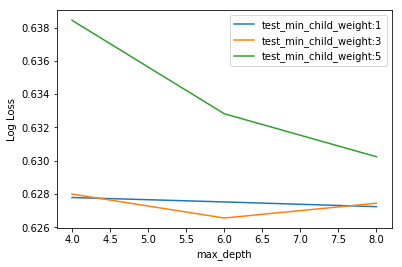

In [13]:
# summarize results
print("Best: %f using %s" % (-gsearch2_1.best_score_, gsearch2_1.best_params_))
test_means = gsearch2_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch2_1.cv_results_[ 'std_test_score' ]
train_means = gsearch2_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch2_1.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch2_1.cv_results_).to_csv('my_preds_maxdepth_min_child_weights_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(max_depth), len(min_child_weight))
train_scores = np.array(train_means).reshape(len(max_depth), len(min_child_weight))

for i, value in enumerate(min_child_weight):
    pyplot.plot(max_depth, -test_scores[i], label= 'test_min_child_weight:'   + str(value))
# for i, value in enumerate(min_child_weight):
#     pyplot.plot(max_depth, -train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'max_depth' )                                                                                                      
pyplot.ylabel( 'Log Loss' )
pyplot.savefig('max_depth_vs_min_child_weght_1.png' )

当前调参结果：  
最优max_depth为6；   
最优min_child_weight为3。